# Questions


#Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost
import sklearn

from sklearn.svm import SVC
from xgboost import plot_importance
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from numpy import std

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import resample
from sklearn.metrics import classification_report

import scipy as sc

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preparation

In [2]:
df_ext = pd.read_excel('/content/drive/My Drive/Colab_Notebooks/covid_detect_clean_oversampled.xlsx')
imp_mean = IterativeImputer(random_state=0, max_iter=10000)
df_ext_iter = imp_mean.fit_transform(df_ext.iloc[:,1:-1].values)
print(df_ext_iter.shape)
df_ext_target = df_ext.iloc[:,-1].values

(354, 14)


# XGB

In [4]:
def results(model):
    print("Best parameters:\n{}".format(model.best_params_))
    print("\nBest cross-validation score:\n{:.4f}".format(model.best_score_))
    print("\nBest estimator:\n{}\n".format(model.best_estimator_))

In [5]:
# oversampled
param_grid = [{'n_estimators' : [50,100,150,200], 
              'max_depth' : [3, 4, 5]}]

xgb_gs = GridSearchCV(xgboost.XGBClassifier(random_state=0), param_grid, cv=5)

X_train, X_test, y_train, y_test = train_test_split(df_ext_iter, df_ext_target, random_state=0)

xgb_gs.fit(X_train, y_train)

print("\nTest score:\n{}\n".format(xgb_gs.score(X_test, y_test)))

results(xgb_gs)


Test score:
0.8876404494382022

Best parameters:
{'max_depth': 4, 'n_estimators': 50}

Best cross-validation score:
0.8113

Best estimator:
XGBClassifier(max_depth=4, n_estimators=50)



## Confusion Matrix & Specificity

In [6]:
confusion = confusion_matrix(y_test, xgb_gs.predict(X_test))
print("Confusion matrix:\n{}\n".format(confusion))

specificity = confusion[1][1]/(confusion[1][1]+confusion[0][1])
print(f'Specificity: {specificity}')
# Find the Specificity
# = TN/(TN+FP)

Confusion matrix:
[[43  3]
 [ 7 36]]

Specificity: 0.9230769230769231


## Precision & Recall

In [9]:
def graph(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()
    plt.xlabel("Threshold")
    plt.grid(True)

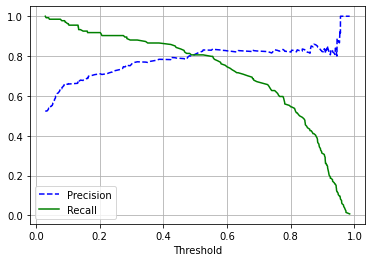

In [10]:
y_scores_xgb = cross_val_predict(xgb_gs.best_estimator_, 
                                 X_train, y_train, cv=5,
                             method="predict_proba")[:,1]

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_xgb)

graph(precisions, recalls, thresholds)

## Threshold

In [11]:
print(classification_report(y_test, xgb_gs.predict(X_test)))

threshold_recall = thresholds[np.argmax(recalls < 0.95)]
print(f'Threshold: {threshold_recall}\n')

y_test_scores_xgb = cross_val_predict(xgb_gs.best_estimator_, 
                                 X_test, y_test, cv=5,
                             method="predict_proba")[:,1]

# apply new threshold
y_test_pred = (y_test_scores_xgb >= threshold_recall)

# Final result of test set
print(classification_report(y_test, y_test_pred.astype(int)))

              precision    recall  f1-score   support

           0       0.86      0.93      0.90        46
           1       0.92      0.84      0.88        43

    accuracy                           0.89        89
   macro avg       0.89      0.89      0.89        89
weighted avg       0.89      0.89      0.89        89

Threshold: 0.13225601613521576

              precision    recall  f1-score   support

           0       0.93      0.59      0.72        46
           1       0.68      0.95      0.80        43

    accuracy                           0.76        89
   macro avg       0.81      0.77      0.76        89
weighted avg       0.81      0.76      0.76        89



## ROC Curve

In [12]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel("FPR")
    plt.ylabel("TPR(Recall)")
    plt.grid(True)

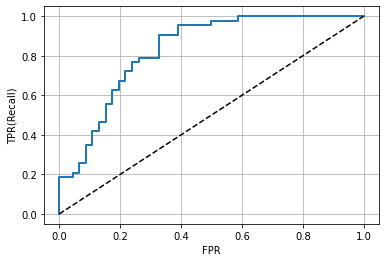

The AUC score: 0.8301314459049545


In [17]:
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_test_scores_xgb)
    
plot_roc_curve(fpr_xgb, tpr_xgb)
plt.show()

print(f"The AUC score: {roc_auc_score(y_test, y_test_scores_xgb)}")

In [14]:
y_test

array([0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0])

In [15]:
y_test_scores_xgb

array([0.02302493, 0.91626877, 0.9461228 , 0.9073606 , 0.13726254,
       0.9740738 , 0.0396742 , 0.03948358, 0.05251127, 0.9721843 ,
       0.04324936, 0.29041627, 0.74199826, 0.958839  , 0.03948358,
       0.96623456, 0.08210715, 0.7219915 , 0.90901846, 0.8214336 ,
       0.94550025, 0.37481952, 0.5222255 , 0.17257363, 0.7571653 ,
       0.40033773, 0.55538666, 0.0209353 , 0.73020035, 0.5287176 ,
       0.87696224, 0.11757718, 0.22131707, 0.24125764, 0.11213249,
       0.6966664 , 0.03178645, 0.03276963, 0.96474594, 0.95021796,
       0.0210218 , 0.2938452 , 0.54680926, 0.9125982 , 0.58894753,
       0.04636756, 0.9599987 , 0.62387186, 0.79902935, 0.02173874,
       0.9447453 , 0.98200905, 0.92349   , 0.5862586 , 0.01457778,
       0.04664655, 0.629968  , 0.97369   , 0.7950297 , 0.9142955 ,
       0.02621964, 0.96547145, 0.04575067, 0.02510933, 0.03755875,
       0.63016975, 0.80645937, 0.09514752, 0.08331355, 0.25999263,
       0.96547145, 0.97959673, 0.93522125, 0.9350483 , 0.96869

# RF

In [ ]:
# RF grid search oversampled
param_grid_rf = [{'n_estimators' : [25,30,40,50,70,90,100,110,120,130,150,200]}]

rf_gs = GridSearchCV(RandomForestClassifier(random_state=0), param_grid_rf, cv=5, n_jobs=-1)

# X_train, X_train, y_train, y_train = train_test_split(df_ext_iter, df_ext_target)

rf_gs.fit(X_train, y_train)

print("\nTest score:\n{}\n".format(rf_gs.score(X_test, y_test)))

results(rf_gs)


Test score:
0.9213483146067416

Best parameters:
{'n_estimators': 150}

Best cross-validation score:
0.8491

Best estimator:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)



## Confusion Matrix & Specificity

In [ ]:
confusion = confusion_matrix(y_test, rf_gs.predict(X_test))
print("Confusion matrix:\n{}\n".format(confusion))

specificity = confusion[1][1]/(confusion[1][1]+confusion[0][1])
print(f'Specificity: {specificity}')
# Find the Specificity
# = TN/(TN+FP)

Confusion matrix:
[[45  1]
 [ 6 37]]

Specificity: 0.9736842105263158


## Precision & Recall

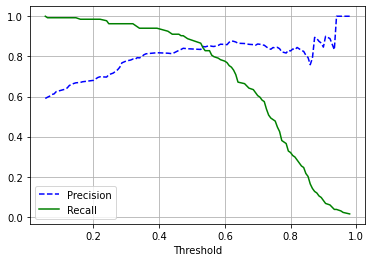

In [ ]:
y_scores_rf = cross_val_predict(rf_gs.best_estimator_, 
                                 X_train, y_train, cv=5,
                             method="predict_proba")[:,1]

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_rf)

graph(precisions, recalls, thresholds)

## Threshold

In [ ]:
print(classification_report(y_test, rf_gs.predict(X_test)))

y_test_scores_rf = cross_val_predict(rf_gs.best_estimator_, 
                                 X_test, y_test, cv=5,
                             method="predict_proba")[:,1]

threshold_recall = thresholds[np.argmax(recalls < 0.95)]
print(f'Threshold: {threshold_recall}\n')

# apply new threshold
y_test_pred = (y_test_scores_rf >= threshold_recall)

# Final result of test set
print(classification_report(y_test, y_test_pred.astype(int)))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93        46
           1       0.97      0.86      0.91        43

    accuracy                           0.92        89
   macro avg       0.93      0.92      0.92        89
weighted avg       0.93      0.92      0.92        89

Threshold: 0.3333333333333333

              precision    recall  f1-score   support

           0       0.90      0.57      0.69        46
           1       0.67      0.93      0.78        43

    accuracy                           0.74        89
   macro avg       0.78      0.75      0.74        89
weighted avg       0.79      0.74      0.73        89



## ROC Curve

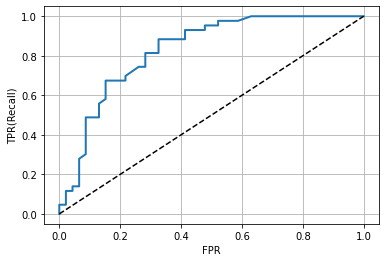

The AUC score: 0.8286147623862488


In [ ]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_test_scores_rf)
    
plot_roc_curve(fpr_rf, tpr_rf)
plt.show()

print(f"The AUC score: {roc_auc_score(y_test, y_test_scores_rf)}")

# DT

In [ ]:
param_grid_dt = [{ 'max_depth' : range(10)}]

dt_gs = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid_dt, cv=5, n_jobs=-1)

# X_train, X_train, y_train, y_train = train_test_split(df_ext_iter, df_ext_target)

dt_gs.fit(X_train, y_train)

print("\nTest score:\n{}\n".format(dt_gs.score(X_test, y_test)))

results(dt_gs)


Test score:
0.8314606741573034

Best parameters:
{'max_depth': 8}

Best cross-validation score:
0.8000

Best estimator:
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')



## Confusion Matrix & Specificity

In [ ]:
confusion = confusion_matrix(y_test, dt_gs.predict(X_test))
print("Confusion matrix:\n{}\n".format(confusion))

specificity = confusion[1][1]/(confusion[1][1]+confusion[0][1])
print(f'Specificity: {specificity}')
# Find the Specificity
# = TN/(TN+FP)

Confusion matrix:
[[43  3]
 [12 31]]

Specificity: 0.9117647058823529


## Precision & Recall

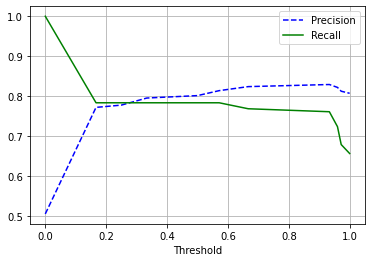

In [ ]:
y_scores_dt = cross_val_predict(dt_gs.best_estimator_, 
                                 X_train, y_train, cv=5,
                             method="predict_proba")[:,1]

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_dt)

graph(precisions, recalls, thresholds)

## Threshold

In [ ]:
print(classification_report(y_test, dt_gs.predict(X_test)))

threshold_recall = thresholds[np.argmax(recalls < 0.9)]
print(f'Threshold: {threshold_recall}\n')

y_test_scores_dt = cross_val_predict(dt_gs.best_estimator_, 
                                 X_test, y_test, cv=5,
                             method="predict_proba")[:,1]

# apply new threshold to test set
y_test_pred = (y_test_scores_dt >= threshold_recall)

# Final result of test set
print(classification_report(y_test, y_test_pred.astype(int)))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85        46
           1       0.91      0.72      0.81        43

    accuracy                           0.83        89
   macro avg       0.85      0.83      0.83        89
weighted avg       0.84      0.83      0.83        89

Threshold: 0.16666666666666666

              precision    recall  f1-score   support

           0       0.72      0.72      0.72        46
           1       0.70      0.70      0.70        43

    accuracy                           0.71        89
   macro avg       0.71      0.71      0.71        89
weighted avg       0.71      0.71      0.71        89



## ROC Curve

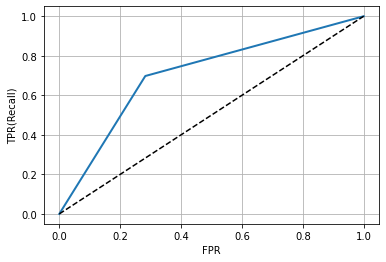

The AUC score: 0.7075328614762386


In [ ]:
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_test_scores_dt)
    
plot_roc_curve(fpr_dt, tpr_dt)
plt.show()

print(f"The AUC score: {roc_auc_score(y_test, y_test_scores_dt)}")

# SVC

In [ ]:
param_grid_svc = [{'C' : [100, 1000, 2000, 10000]}]

svc_gs = GridSearchCV(SVC(random_state=0), param_grid_svc, cv=5, n_jobs=-1)

# X_train, X_train, y_train, y_train = train_test_split(df_ext_iter, df_ext_target)

svc_gs.fit(X_train, y_train)

print("\nTest score:\n{}\n".format(svc_gs.score(X_test, y_test)))

results(svc_gs)


Test score:
0.8426966292134831

Best parameters:
{'C': 1000}

Best cross-validation score:
0.7660

Best estimator:
SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)



## Confusion Matrix & Specificity

In [ ]:
confusion = confusion_matrix(y_test, svc_gs.predict(X_test))
print("Confusion matrix:\n{}\n".format(confusion))

specificity = confusion[1][1]/(confusion[1][1]+confusion[0][1])
print(f'Specificity: {specificity}')
# Find the Specificity
# = TN/(TN+FP)

Confusion matrix:
[[42  4]
 [10 33]]

Specificity: 0.8918918918918919


## Precision & Recall

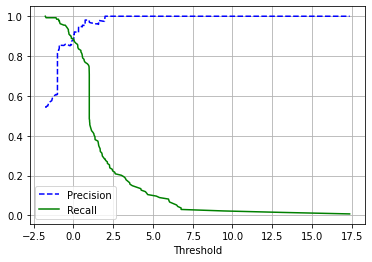

In [ ]:
y_scores_svc = svc_gs.decision_function(X_train)

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_svc)

graph(precisions, recalls, thresholds)

## Threshold

In [ ]:
print(classification_report(y_test, svc_gs.predict(X_test)))

threshold_recall = thresholds[np.argmax(recalls < 0.8)]
print(f'Threshold: {threshold_recall}\n')

y_test_scores_svc = svc_gs.decision_function(X_test)

# apply new threshold to test set
y_test_pred = (y_test_scores_dt >= threshold_recall)

# Final result of test set
print(classification_report(y_test, y_test_pred.astype(int)))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86        46
           1       0.89      0.77      0.82        43

    accuracy                           0.84        89
   macro avg       0.85      0.84      0.84        89
weighted avg       0.85      0.84      0.84        89

Threshold: 0.5658077503502567

              precision    recall  f1-score   support

           0       0.72      0.72      0.72        46
           1       0.70      0.70      0.70        43

    accuracy                           0.71        89
   macro avg       0.71      0.71      0.71        89
weighted avg       0.71      0.71      0.71        89



## ROC Curve

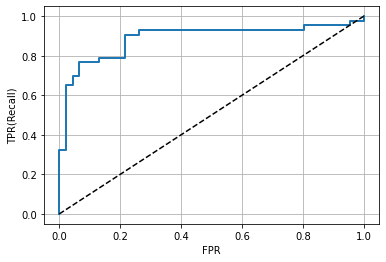

The AUC score: 0.8877654196157735


In [ ]:
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_test_scores_svc)
    
plot_roc_curve(fpr_svc, tpr_svc)
plt.show()

print(f"The AUC score: {roc_auc_score(y_test, y_test_scores_svc)}")

# Light GBM

In [ ]:
import lightgbm as lgb

param_grid_lgb = [{'n_estimators' : range(50, 200, 25), 
                  'max_depth' : [3, 4, 5, 6, 7]}] 

lgb_gs = GridSearchCV(lgb.LGBMClassifier(random_state=0), param_grid_lgb, cv=5, n_jobs=-1)

# X_train, X_train, y_train, y_train = train_test_split(df_ext_iter, df_ext_target)

lgb_gs.fit(X_train, y_train)

print("\nTest score:\n{}\n".format(lgb_gs.score(X_test, y_test)))

results(lgb_gs)


Test score:
0.8314606741573034

Best parameters:
{'max_depth': 3, 'n_estimators': 50}

Best cross-validation score:
0.8038

Best estimator:
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=3,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=50, n_jobs=-1, num_leaves=31, objective=None,
               random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)



## Confusion Matrix & Specificity

In [ ]:
confusion = confusion_matrix(y_test, lgb_gs.predict(X_test))
print("Confusion matrix:\n{}\n".format(confusion))

specificity = confusion[1][1]/(confusion[1][1]+confusion[0][1])
print(f'Specificity: {specificity}')
# Find the Specificity
# = TN/(TN+FP)

Confusion matrix:
[[40  6]
 [ 9 34]]

Specificity: 0.85


## Precision & Recall

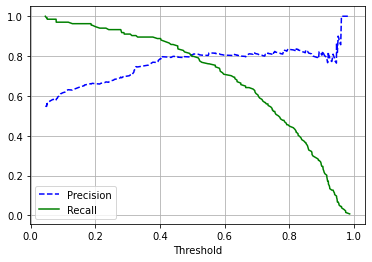

In [ ]:
y_scores_lgb = cross_val_predict(lgb_gs.best_estimator_, 
                                 X_train, y_train, cv=5,
                             method="predict_proba")[:,1]

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_lgb)

graph(precisions, recalls, thresholds)

## Threshold

In [ ]:
print(classification_report(y_test, lgb_gs.predict(X_test)))

threshold_recall = thresholds[np.argmax(recalls < 0.9)]
print(f'Threshold: {threshold_recall}\n')

y_test_scores_lgb = cross_val_predict(lgb_gs.best_estimator_, 
                                 X_test, y_test, cv=5,
                             method="predict_proba")[:,1]

# apply new threshold to test set
y_test_pred = (y_test_scores_lgb >= threshold_recall)

# Final result of test set
print(classification_report(y_test, y_test_pred.astype(int)))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84        46
           1       0.85      0.79      0.82        43

    accuracy                           0.83        89
   macro avg       0.83      0.83      0.83        89
weighted avg       0.83      0.83      0.83        89

Threshold: 0.33071190180328597

              precision    recall  f1-score   support

           0       0.87      0.74      0.80        46
           1       0.76      0.88      0.82        43

    accuracy                           0.81        89
   macro avg       0.82      0.81      0.81        89
weighted avg       0.82      0.81      0.81        89



##ROC Curve

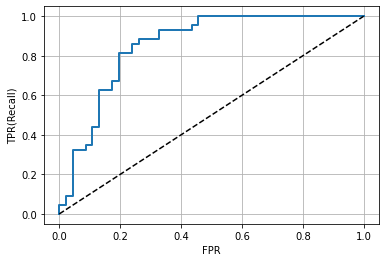

The AUC score: 0.8533872598584428


In [ ]:
fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(y_test, y_test_scores_lgb)
    
plot_roc_curve(fpr_lgb, tpr_lgb)
plt.show()

print(f"The AUC score: {roc_auc_score(y_test, y_test_scores_lgb)}")

# Total

In [ ]:
list_model = ['DT', 'RF', 'XGB', 'SVC', 'LGB']
dic_model = {'DT':dt_gs.best_estimator_, 'RF':rf_gs.best_estimator_, 'XGB':xgb_gs.best_estimator_, 'SVC':svc_gs.best_estimator_, 'LGB':lgb_gs.best_estimator_}
dic_fpr = {'DT':fpr_dt, 'RF':fpr_rf, 'XGB':fpr_xgb, 'SVC':fpr_svc, 'LGB':fpr_lgb}
dic_tpr = {'DT':tpr_dt, 'RF':tpr_rf, 'XGB':tpr_xgb, 'SVC':tpr_svc, 'LGB':tpr_lgb}
dic_y_scores = {'DT':y_test_scores_dt, 'RF':y_test_scores_rf, 'XGB':y_test_scores_xgb, 'SVC':y_test_scores_svc, 'LGB':y_test_scores_lgb}

## Precision & Recall

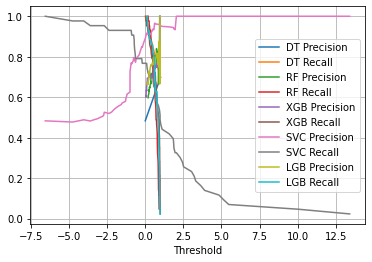

In [ ]:
for model in list_model:
    precisions, recalls, thresholds = precision_recall_curve(y_test, dic_y_scores[model])

    plt.plot(thresholds, precisions[:-1], label=f"{model} Precision")
    plt.plot(thresholds, recalls[:-1], label=f"{model} Recall")
    plt.legend()
    plt.xlabel("Threshold")
    plt.grid(True)

## ROC Curve

DT's AUC score: 0.7075328614762386
RF's AUC score: 0.8286147623862488
XGB's AUC score: 0.8301314459049545
SVC's AUC score: 0.8877654196157735
LGB's AUC score: 0.8533872598584428


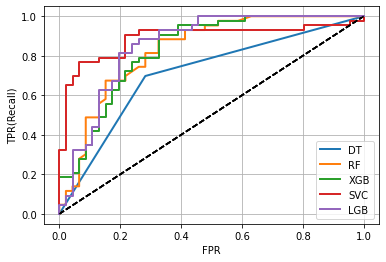

In [ ]:
for model in list_model:
    plt.plot(dic_fpr[model], dic_tpr[model], linewidth=2, label=model)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel("FPR")
    plt.ylabel("TPR(Recall)")
    plt.legend()
    plt.grid(True)
    print(f"{model}'s AUC score: {roc_auc_score(y_test, dic_y_scores[model])}")

## Confidence Interval

In [ ]:
preicison_150 = pd.read_excel('/content/drive/My Drive/Colab_Notebooks/20iter_precision.xlsx')
recall_150 = pd.read_excel('/content/drive/My Drive/Colab_Notebooks/20iter_recall.xlsx')
specificity_150 = pd.read_excel('/content/drive/My Drive/Colab_Notebooks/20iter_specificity.xlsx')

In [ ]:
preicison_177 = pd.read_excel('/content/drive/My Drive/Colab_Notebooks/177_precision.xlsx')
recall_177 = pd.read_excel('/content/drive/My Drive/Colab_Notebooks/177_recall.xlsx')
specificity_177 = pd.read_excel('/content/drive/My Drive/Colab_Notebooks/177_specificity.xlsx')

In [ ]:
selected_precision = pd.read_excel('/content/drive/My Drive/Colab_Notebooks/selected_models_precision.xlsx')

### Precision

In [ ]:
#preicison_150 = selected_precision
df_ci_precision = pd.DataFrame(columns=['Model_Imput', 'CI_left', 'CI_right'])
s = 0
for i in preicison_150.columns:
  scores = preicison_150[i].values
  mean = scores.mean()
  std = scores.std()
  ci = np.array([sc.stats.t.interval(0.95, len(scores), mean, std)])
  df_ci_precision.loc[s] = [i,ci[0][0],ci[0][1]]
  s+=1
df_ci_precision

,Model_Imput,CI_left,CI_right
0,mean SVC,0.672870,0.926147
1,median SVC,0.674678,0.947883
2,knn SVC,0.634337,0.898604
3,iter SVC,0.638614,0.940437
4,mean DT,0.713635,0.979927
5,median DT,0.695660,0.965234
6,knn DT,0.700530,0.972420
7,iter DT,0.717991,0.967165
8,mean RF,0.771350,1.001848
9,median RF,0.784019,0.984918


1. iter LGB
2. mean XGB
3. mean LGB
4. without LGB

In [ ]:
df_ci_precision = df_ci_precision[8:]

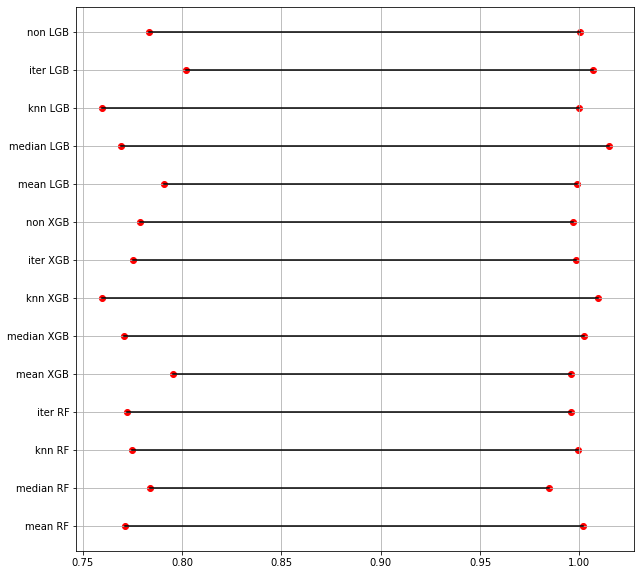

In [ ]:
plt.figure(figsize=(10,10))
for i in range(len(df_ci_precision)):
  plt.plot([df_ci_precision.iloc[i,1],df_ci_precision.iloc[i,2]],[i+1,i+1], c='k')
  plt.scatter(df_ci_precision.iloc[i,1], i+1, c='r')
  plt.scatter(df_ci_precision.iloc[i,2], i+1, c='r')
plt.yticks(range(1,len(df_ci_precision)+1), df_ci_precision['Model_Imput'])
plt.grid();

### Recall/Sensitivity

In [ ]:
df_ci_recall = pd.DataFrame(columns=['Model_Imput', 'CI_left', 'CI_right'])
s = 0
for i in recall_150.columns:
  scores = recall_150[i].values
  mean = scores.mean()
  std = scores.std()
  ci = np.array([sc.stats.t.interval(0.95, len(scores), mean, std)])
  df_ci_recall.loc[s] = [i,ci[0][0],ci[0][1]]
  s+=1
df_ci_recall

,Model_Imput,CI_left,CI_right
0,mean SVC,0.504071,0.927929
1,median SVC,0.484716,0.866618
2,knn SVC,0.558196,0.883137
3,iter SVC,0.502238,0.883096
4,mean DT,0.699087,1.007579
5,median DT,0.684218,1.010449
6,knn DT,0.705440,0.989227
7,iter DT,0.717549,1.007118
8,mean RF,0.779605,1.031061
9,median RF,0.787691,1.016975


1. iter RF
2. mean RF
3. mean XGB
4. median XGB/without XGB/knn LGB

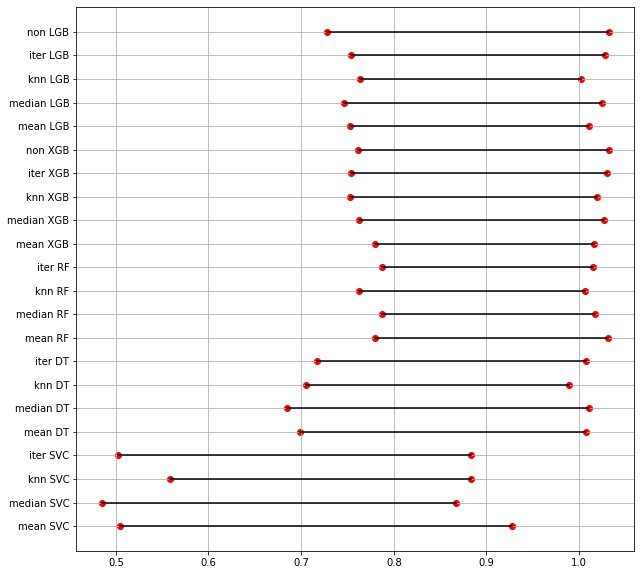

In [ ]:
plt.figure(figsize=(10,10))
for i in range(len(df_ci_recall)):
  plt.plot([df_ci_recall.iloc[i,1],df_ci_recall.iloc[i,2]],[i+1,i+1], c='k')
  plt.scatter(df_ci_recall.iloc[i,1], i+1, c='r')
  plt.scatter(df_ci_recall.iloc[i,2], i+1, c='r')
plt.yticks(range(1,len(df_ci_recall)+1), df_ci_recall['Model_Imput'])
plt.grid();

### F1

In [ ]:
# df_ci_f1 = pd.DataFrame(columns=['Model_Imput', 'CI_left', 'CI_right'])
# s = 0
# for i in df_f1.columns:
#   scores = df_f1[i].values
#   mean = scores.mean()
#   std = scores.std()
#   ci = np.array([sc.stats.t.interval(0.95, len(scores), mean, std)])
#   df_ci_f1.loc[s] = [i,ci[0][0],ci[0][1]]
#   s+=1
# df_ci_f1

1. median RF
2. mean XGB
3. iter LGB
4. iter RF

In [ ]:
plt.figure(figsize=(10,10))
for i in range(len(df_ci_f1)):
  plt.plot([df_ci_f1.iloc[i,1],df_ci_f1.iloc[i,2]],[i+1,i+1], c='k')
  plt.scatter(df_ci_f1.iloc[i,1], i+1, c='r')
  plt.scatter(df_ci_f1.iloc[i,2], i+1, c='r')
plt.yticks(range(1,len(df_ci_f1)+1), df_ci_f1['Model_Imput'])
plt.grid();

### Specificity

In [ ]:
df_ci_specificity = pd.DataFrame(columns=['Model_Imput', 'CI_left', 'CI_right'])
s = 0
for i in specificity_150.columns:
  scores = specificity_150[i].values
  mean = scores.mean()
  std = scores.std()
  ci = np.array([sc.stats.t.interval(0.95, len(scores), mean, std)])
  df_ci_specificity.loc[s] = [i,ci[0][0],ci[0][1]]
  s+=1
df_ci_specificity

,Model_Imput,CI_left,CI_right
0,mean SVC,0.628470,0.920711
1,median SVC,0.679336,0.951973
2,knn SVC,0.642884,0.899319
3,iter SVC,0.640939,0.945726
4,mean DT,0.712005,0.959211
5,median DT,0.699403,0.993941
6,knn DT,0.707668,0.975966
7,iter DT,0.708248,0.957408
8,mean RF,0.768861,0.999321
9,median RF,0.776944,0.978813


1. iter LGB
2. median XGB
3. mean LGB
4. iter XGB

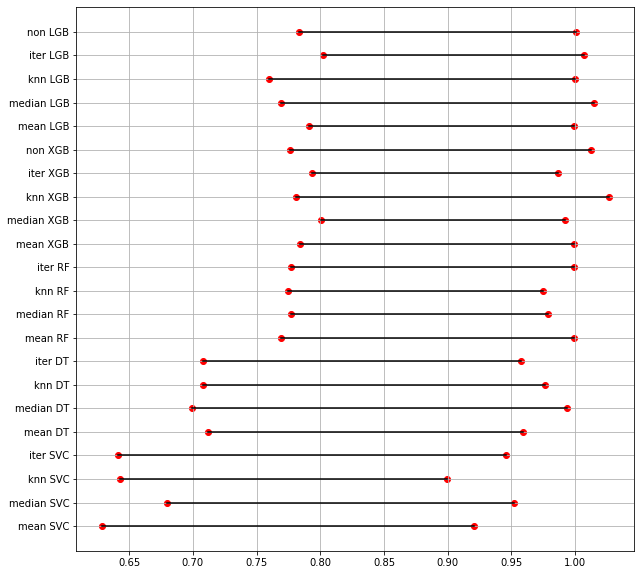

In [ ]:
plt.figure(figsize=(10,10))
for i in range(len(df_ci_specificity)):
  plt.plot([df_ci_specificity.iloc[i,1],df_ci_specificity.iloc[i,2]],[i+1,i+1], c='k')
  plt.scatter(df_ci_specificity.iloc[i,1], i+1, c='r')
  plt.scatter(df_ci_specificity.iloc[i,2], i+1, c='r')
plt.yticks(range(1,len(df_ci_specificity)+1), df_ci_specificity['Model_Imput'])
plt.grid();